# Utilizing Cyclostationary Signal Processing Techniques. 
## Techniques used
1. Cyclic Autocorrelation Function (CAF)
2. Spectral Correlation Function (SCF)


## Can you accomplish the following...
1. Detect different modulation schemes?
    1. {2, 4, 8}-PSK, {16, 32, 64}-QPSK 
2. Detect the number of unique symbols sent?
3. Detect the length of the repeated symbols?
4. Is this detection sensitive to AWGN?



## Simplifications

1. No pulse shaping filter is used... Instead a simple repeated symbol scheme is used. 
    1. (**Not tested**) Justification... As long as the pulse shaping function that is utilized is a linearly time invariant filter, then the signals periodic properties are still intact. This should translate to similar results while speeding up computation as you can potentially target specific frequency bins.
    
    1. (**Support**) if $S(t)$ is periodic with period $T$,  $S(t) = S(t+k T) \quad k \in \mathbf{Z}$ and let $h$ be a LTI filter... $ h(t_1) = h(t_2) \quad \forall t_1,t_2 \in \mathbf{R}$, with, 
    the convolution denoted as $\circledast$  

 $$ \qquad
        (S \circledast h)(t) = \int_{-\infty}^{\infty}S(t)h(t-\tau) d{\tau}            \equiv  \qquad
        (S \circledast h)(t+kT) = \int_{-\infty}^{\infty}S(t+kT)h(t+kT-\tau) d{\tau}   
 $$
 
 By $h$ being LTI, and $S(t)$ having period $T$

# Simulated Data

In [64]:
# Imports
%matplotlib notebook 
# optional # %matplotlib inline
import numpy as np
from commpy import PSKModem, QAMModem
from matplotlib import pyplot as plt
from matplotlib import pyplot  
from scipy.signal import find_peaks
import pandas as pd
import scipy.stats as st
from scipy import signal

from sklearn import mixture



In [65]:
#
# Set up the paramaters
##
nsymbols=16
repeats_per_symbol = 12
samples_per_second = 100
message_len = 3000
total_samples = repeats_per_symbol*message_len
baseband_carrier_freq = 20 # fc center frequency 
noise_sd = 0.01 # noise 
# calculate
duration = total_samples//samples_per_second
time = np.linspace(0, duration, total_samples)/samples_per_second  # clock time of each sample
dt = duration/(total_samples*samples_per_second)

freqs = np.fft.ifftshift(np.fft.fftfreq(len(time), dt))
print(f" Set Fs: {1/dt} \n Set dt: {dt} \n Total_Samples: {len(time)}")

params = {
    'nsymbols':nsymbols,
    'repeats_per_symbol'   :  repeats_per_symbol,
    'samples_per_second'  :   samples_per_second,
    'message_len'   :   message_len ,
    'total_samples'  :  total_samples ,
    'baseband_carrier_freq' :   baseband_carrier_freq,
    'noise_sd'  :   noise_sd ,
    'duration' :  duration, 
    'time'  :   time, 
    'dt'  :   dt,
    'freqs'  :   freqs
    }

 Set Fs: 10000.0 
 Set dt: 0.0001 
 Total_Samples: 36000


In [86]:
# Definition to get test data
def gen_df(modulation=2, params={}):
    print("generating df... ")
    # set params
    nsymbols =  params["nsymbols"]
    repeats_per_symbol = params["repeats_per_symbol"]
    samples_per_second = params["samples_per_second"]
    message_len = params["message_len"]
    total_samples = params["total_samples"]
    baseband_carrier_freq = params["baseband_carrier_freq"]
    noise_sd = params["noise_sd"]
    duration = params["duration"]
    time =  params["time"]
    dt = params["dt"]
    freqs = params["freqs"]
    
    # define values...     
    baseband_signal =  np.exp(1j*2*np.pi*time*baseband_carrier_freq)
    baseband_inv = np.exp(-1j*2*np.pi*time*baseband_carrier_freq)
    
    # define constellation
    m = QAMModem(nsymbols)
    con = m.constellation
    con = con/np.max(np.abs(con))  # power normablizing
    
    # set message
    symbol_message = np.random.randint(0, nsymbols, message_len)
    message_with_repeats = np.repeat(symbol_message, repeats_per_symbol)
    
    # An IQ encoding of a message is just a symbol lookup table
    iq_encoded_message = con[message_with_repeats]
    iq_encoded_message
    
    # Modulate the encoding unto the baseband cf
    modulated = iq_encoded_message*baseband_signal
    noise = np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) + \
        1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
    
    # Channel refers to the idea of a channel model with experimental effects.  Here AWGN.
    channel_iq = modulated + noise
    
    # Unmodulate with baseband inv to get the original modulation with noise effects
    unmodulated = channel_iq*baseband_inv
    
    data = {
        "modulated": modulated,
        "unmodulated":unmodulated,
        "channel_iq": channel_iq,
        "iq_encoded_message": iq_encoded_message,
        "baseband_signal": baseband_signal,
        "noise_vec":noise
        }
    
    df = pd.DataFrame(data)
    return params, df
    
    
params, df = gen_df(modulation=2, params=params)  

print("columns", [col for col in df.columns.values])
# optional prints... 

# print(df.describe())
# print(df.info())

generating df... 
columns ['modulated', 'unmodulated', 'channel_iq', 'iq_encoded_message', 'baseband_signal', 'noise_vec']


In [88]:
## Helper functions
def get_iq(df_s):
    """
    transform a df series of complex vals
    into the dataFrame of real and imaginary columns.
    Return: pandas.DataFrame
    """    
    dfc = {
        "i": (df_s.values).real,
        "q": (df_s.values).imag
    }
    
    return pd.DataFrame(dfc)

def detect_freq_range(f_caf, alpha=0.95):
    """
    View lagged correlation of signal to determine
    a frequency responce and filter out the decaying harmonics...
    Input: fft({lagged correlation function})
    
    """    
    y = np.where(np.log(np.abs(f_caf)) > 0, np.log(np.abs(f_caf)), np.nan)
    
    peaks_caf =  find_peaks(y)[0]
    
    #create 95% confidence interval for population mean weight
    lb, ub = st.t.interval(alpha=alpha,
                  df=len(peaks_caf)-1,
                  loc=np.mean(peaks_caf),
                  scale=st.sem(peaks_caf)) 
    
    return lb, ub, peaks_caf, y

def pplot(df_s, df):
    """
    df_s is a dataframe series containing complex values for a scatter plot
    df is the full data frame so I can access the noise levels for coloring
    """
    df_iq = get_iq(df_s)
    color_ = 1 - np.abs(df["noise_vec"])/np.max(np.abs(df["noise_vec"]))
    df_iq["complement_noise_lvl"] = color_
    plt.close("all")
    df_iq.plot.scatter(x="i", y="q",c="complement_noise_lvl", colormap='viridis', alpha=color_ )
    plt.title(df_s.name)
    plt.show()

<IPython.core.display.Javascript object>


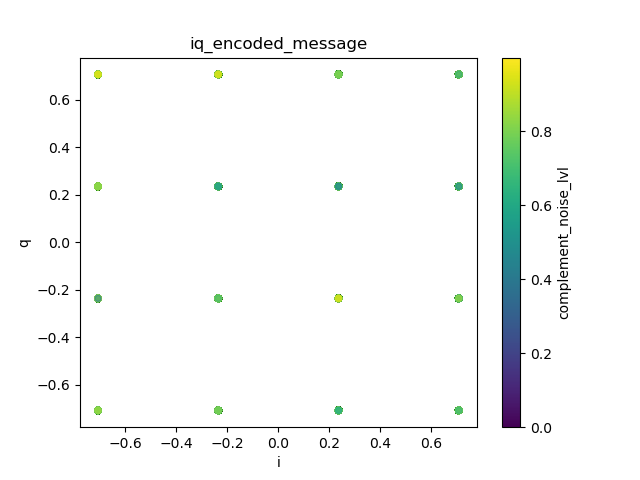

In [101]:
# defint input data... and plot iq 

x = np.asarray(df["iq_encoded_message"])

pplot(df["iq_encoded_message"], df)

# Cycle Autocorrelation Function (CAF)

1. First calculate the asymetric CAF $\hat{R}_{\tau}^{\alpha}$
2. Place in the frequency domain, apply a shift of $-\pi \alpha \tau $ to all freqs alpha and calculate the symmetric CAF

In [140]:
# Calculate the Asymetric CAF
# first calculate the asymetric Spectral Correlation Function,
# apply a shift to the Asym_SCF and inverse fft to get the Symmetric CAF value.

# print(x)

auto_cor = signal.correlate(x,
                       x,
                       mode="same")/len(x)

conj_auto_cor = signal.correlate(x,
                       np.conj(x),
                       mode="same")/len(x)

lags = signal.correlation_lags(x.size, x.size, mode="same")

a_cor = auto_cor[lags]
c_cor = conj_auto_cor[lags]


"""
view auto_correlation as an 
fft, and extrapulate the frequency range
with the highest periodic components.
"""

asym_scf = np.fft.fftshift(np.fft.fft(auto_cor))   
conj_asym_scf = np.fft.fftshift(np.fft.fft(conj_auto_cor))

# filter potential alpha values down to only those that describe
# the periodic components within the autocorrelate function.
lb, ub, peaks, y = detect_freq_range(asym_scf, alpha=0.99)
Taus = lags[int(lb):int(ub)]


# Symmetric CAF around pre filtered alphas
alpha = lags[peaks]*dt

s_scf = np.outer(np.exp(1j*np.pi*alpha), asym_caf)


print(s_scf.shape)


df_scf = pd.DataFrame(s_scf)
df_scf.index = [f"{np.round(f, 4)}Hz" for f in alpha]
df_scf.columns = [f"{np.round(f*dt, 4)}Hz" for f in freqs]
cols = df_scf.columns



(725, 36000)


<IPython.core.display.Javascript object>


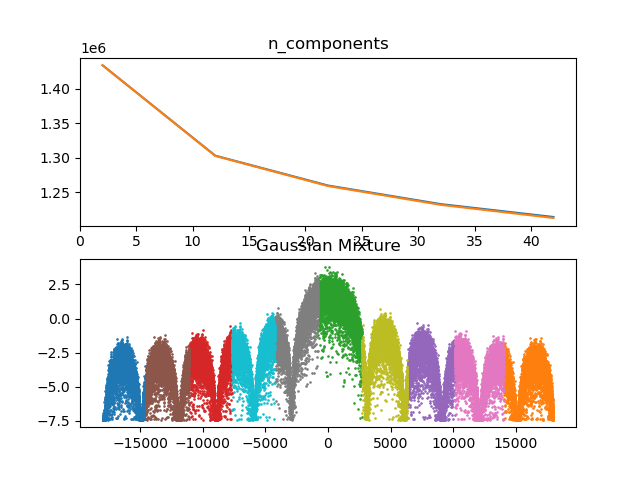

In [60]:
data = np.log(np.abs(asym_caf))



# testing a mixed gaussian model
# 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


# n_samples
n_samples = len(data)

# data for training set
# lags and values are my 2 features
X_train = np.vstack([lags, data]).transpose()

# finding optimal n_components
n_components = np.arange(2, 52, 10)


plt.close("all")
fig, (ax1, ax2) = plt.subplots(2, 1)
# generate models
models = [mixture.GaussianMixture(n_components=n,
                                  covariance_type='spherical').fit(X_train) for n in n_components ]



ax1.plot(n_components, [m.bic(X_train) for m in models], label='BIC')
ax1.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
ax1.set_title('n_components')

# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=10, covariance_type='spherical')
gmm.fit(X_train)

X = X_train
Y_ = gmm.predict(X)



group = list(set(list(Y_)))
for i in group:
    ax2.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8)
ax2.set_title("Gaussian Mixture")

plt.show()





In [50]:
print(gmm.predict_proba(X_train))

[[1.30810313e-061 0.00000000e+000 4.05548264e-010 ... 1.14198968e-108
  0.00000000e+000 3.24245676e-237]
 [5.00241438e-061 0.00000000e+000 6.05114841e-010 ... 7.89595304e-108
  0.00000000e+000 7.25201052e-236]
 [1.91236480e-060 0.00000000e+000 9.06374635e-010 ... 5.46382307e-107
  0.00000000e+000 1.61348942e-234]
 ...
 [2.00707347e-163 4.33596033e-026 3.88560062e-276 ... 7.69401094e-123
  3.53072948e-009 1.80381413e-050]
 [2.04976612e-164 1.76821382e-026 2.11315227e-277 ... 1.00192607e-123
  2.23007982e-009 4.96914453e-051]
 [2.10684185e-165 7.22774540e-027 1.15565510e-278 ... 1.30980001e-124
  1.40737376e-009 1.37605091e-051]]


<IPython.core.display.Javascript object>


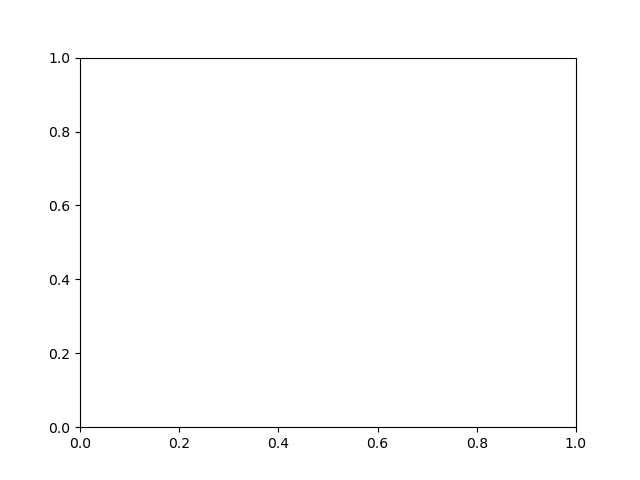

ValueError: x and y must be the same size

In [56]:
plt.close("all")
plt.scatter(Taus*dt, data, 0.2)
plt.scatter(lags, np.log((np.abs(asym_caf))), 0.1)
plt.show()

<IPython.core.display.Javascript object>


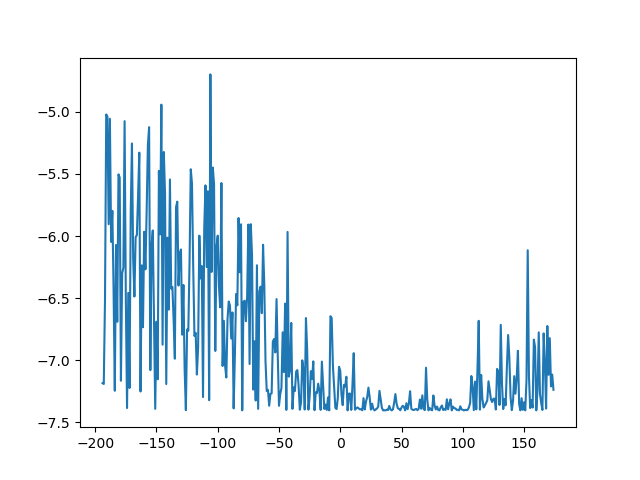

In [41]:
lb , ub = int(lb), int(ub)
t_data = np.log(np.abs(asym_caf))[Taus]

plt.close("all")
plt.plot(Taus, t_data)
plt.show()